# Safer bike routes based on past crashes

## Preliminary analysis using car crash data in Somerville, MA

The eventual goal of this project is to design a way for cyclists to get around Somerville safely. 
For me, this is useful for my daily bike commutes, but it could also be useful for delivery service companies.

In final form this would involve making a model of the streets of Somerville, predicting which streets you are most likely to get hit on, and directing you to safer routes.

The data is from MassDOT. I used 2004-2020 Somerville data but other areas could be used as well. 
[The data can be downloaded here](https://apps.impact.dot.state.ma.us/cdp/home)

As a first pass, I explored the data to see how crashes are happening in Somerville and when bikers are getting hit.

In [225]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as ols

In [226]:
# Read in the data and take a look
dat = pd.read_csv(r"Downloads/CrashDetails2.csv",skiprows=6)
dat.head()

,RMV Crash Number,City Town Name,Crash Date,Crash Time,Crash Severity,Maximum Injury Severity Reported,Number of Vehicles,Total Nonfatal Injuries,Total Fatal Injuries,Manner of Collision,...,Ambient Light,Weather Condition,At Roadway Intersection,Distance From Nearest Roadway Intersection,Distance From Nearest Milemarker,Distance From Nearest Exit,Distance From Nearest Landmark,Non Motorist Type,X Cooordinate,Y Cooordinate
0,1615315,SOMERVILLE,01-Jan-2002,12:00 PM,Not Reported,Not reported,2.0,0.0,0.0,"Sideswipe, same direction",...,Dusk,Clear,Rte 28,Rte 28,NaN,NaN,NaN,NaN,NaN,NaN
1,1601349,SOMERVILLE,01-Jan-2002,12:55 PM,Non-fatal injury,Non-fatal injury - Possible,2.0,1.0,0.0,Not reported,...,Daylight,Clear/Rain,MYSTIC AVENUE Rte 38 / WHEATLAND STREET,MYSTIC AVENUE Rte 38 / WHEATLAND STREET,NaN,NaN,NaN,NaN,233994.515409,904924.500212
2,1469235,SOMERVILLE,01-Jan-2002,12:55 PM,Non-fatal injury,Non-fatal injury - Non-incapacitating,2.0,2.0,0.0,Angle,...,Daylight,Clear,MYSTIC AVENUE Rte 38 N / WHEATLAND STREET,MYSTIC AVENUE Rte 38 N / WHEATLAND STREET,NaN,NaN,NaN,NaN,233994.515409,904924.500212
3,1611964,SOMERVILLE,01-Jan-2002,6:15 PM,Not Reported,Not Applicable,2.0,0.0,0.0,"Sideswipe, opposite direction",...,Dark - roadway not lighted,"Sleet, hail (freezing rain or drizzle)",NaN,Rte 93 N,NaN,NaN,ON RAMP TO MARTHA ROAD,NaN,NaN,NaN
4,1418228,SOMERVILLE,01-Jan-2002,7:15 PM,Not Reported,Not Applicable,2.0,0.0,0.0,Not reported,...,Not reported,Not Reported,/ / BEACON STREET,/ / BEACON STREET / SACRAMENTO STREET,NaN,NaN,NaN,NaN,231896.906191,903725.500147


## First, we'll look at all car crashes over time.

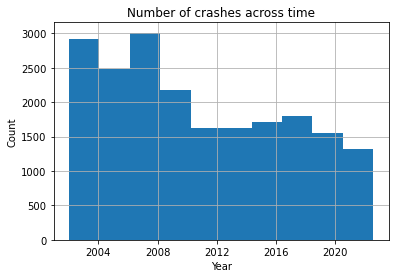

In [227]:
dat['datetime'] = pd.to_datetime(dat["Crash Date"] + ' ' + dat["Crash Time"])

dat['day_of_week'] = dat["datetime"].dt.day_name()

dat.hist('datetime')

plt.title('Number of crashes across time')
plt.ylabel('Count')
plt.xlabel('Year');

## We can see that they're going down over the years. Great!

## Next, let's look at how crashes occur throughout the week.

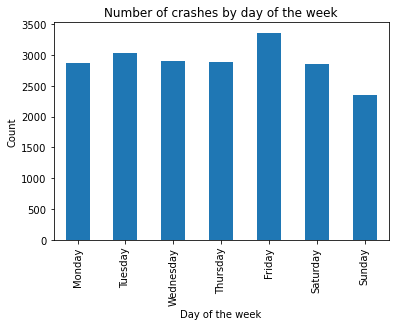

In [228]:
dat["day_of_week"].value_counts()\
[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']].plot(kind='bar')

plt.title('Number of crashes by day of the week')
plt.ylabel('Count')
plt.xlabel('Day of the week');

## It looks like there are slightly more car crashes on Fridays

## Now let's look across time during a day

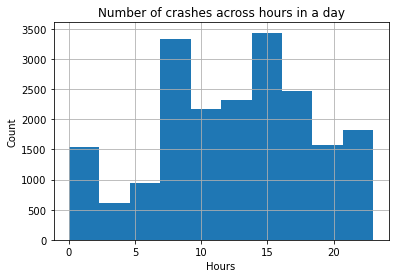

In [229]:
dat['datetime'].dt.hour.hist()

plt.title('Number of crashes across hours in a day')
plt.ylabel('Count')
plt.xlabel('Hours');

We can see that there are differences here, but let's break the hours down into more interpretable sections of the day like "Evening" or "Morning"

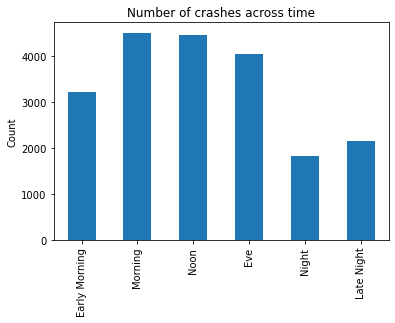

In [230]:
b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
dat['time_of_day'] = pd.cut(dat['datetime'].dt.hour, bins=b, labels=l, include_lowest=True)

dat["time_of_day"].value_counts()[['Early Morning','Morning','Noon','Eve','Night','Late Night']].plot(kind='bar')

plt.title('Number of crashes across time')
plt.ylabel('Count');

## It looks like there's more crashes during the day than at night, which makes sense as there are likely more cars on the road.

Now let's look at what kind of non-motorists are involved in car crashes.


In [231]:
set_list = set(dat["Non Motorist Type"]) 
print("The unique elements of the input list using set():\n") 
list_NMT = (list(set_list))
print(list_NMT)


The unique elements of the input list using set():

[nan, ' P4: Skater', ' P2: Pedestrian / P3: Pedestrian / P4: Pedestrian / P5: Pedestrian', ' P3: Pedestrian / P4: Pedestrian / P5: Pedestrian', ' P6: Pedestrian', ' P2: Cyclist / P3: Cyclist / P4: Cyclist', ' P3: Skater', ' P3: Pedestrian / P2: Pedestrian', ' P2: Skater', ' P3: Train/trolley passenger', ' P3: Other / P2: Other', ' P1: Pedestrian / P2: Pedestrian', ' P2: Pedestrian / P4: Pedestrian', ' P5: Other', ' P4: Cyclist / P5: Cyclist', ' P2: Pedestrian / P3: Other / P4: Pedestrian / P5: Pedestrian', ' P1: Other', ' P4: Pedestrian', ' P4: Pedestrian / P5: Pedestrian', ' P1: Cyclist / P2: Other', ' P2: Other', ' P2: Pedestrian / P3: Pedestrian', ' P4: Other', ' P1: Skater', ' P2: Pedestrian / P3: Pedestrian / P4: Pedestrian', ' P5: Pedestrian', ' P4: Cyclist', ' P2: Cyclist / P3: Other', ' P3: Pedestrian / P4: Pedestrian', ' P5: Cyclist', ' P3: Pedestrian', ' P2: Cyclist / P3: Cyclist', ' P3: Other', ' P3: Cyclist', ' P6: Cyclist

There's a lot of different people involved, but let's focus on the cyclists getting hit and compare them to those crashes when non-motorists were not involved (a car hitting an object or another car)

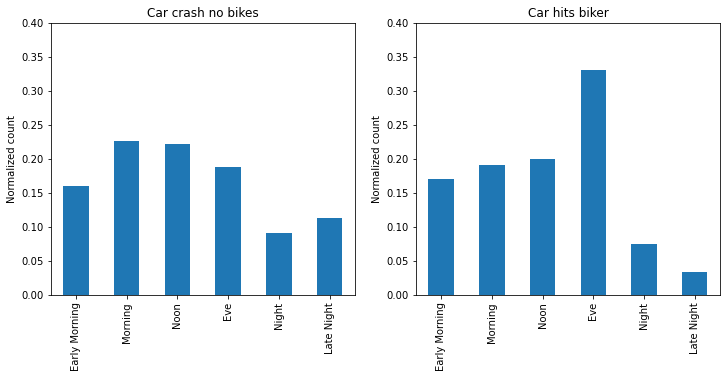

In [232]:
isbike = dat["Non Motorist Type"].str.contains('Cyclist',na=False,case=False)
iscar = dat["Non Motorist Type"].isna()

has_cyc_tm = dat[isbike]["time_of_day"]
only_car_tm = dat[iscar]["time_of_day"]

plt.figure(figsize=[12,5])

ax1 = plt.subplot(121)
only_car_tm.value_counts(normalize=True)\
[['Early Morning','Morning','Noon','Eve','Night','Late Night']].plot(kind='bar')
ax1.set(ylim=(0, .4))
plt.title('Car crash no bikes')
plt.ylabel('Normalized count')

ax2 = plt.subplot(122)
has_cyc_tm.value_counts(normalize=True)\
[['Early Morning','Morning','Noon','Eve','Night','Late Night']].plot(kind='bar')
ax2.set(ylim=(0, .4))
plt.title('Car hits biker')
plt.ylabel('Normalized count');



## It seems that car crashes without bikes happen at all times of day, but cyclists tend to get hit in the evening

In [233]:
A = has_cyc_tm.value_counts()\
                                [['Early Morning','Morning','Noon','Eve','Night','Late Night']]
A2 = A.rename_axis('unique_values').to_frame('counts')

B = dat[isbike | iscar]["time_of_day"].value_counts()\
                                [['Early Morning','Morning','Noon','Eve','Night','Late Night']]
B2 = B.rename_axis('unique_values').to_frame('counts')

C = [[A], [B]]
chi2p = stats.chi2_contingency(C)
print('p = ' + str(chi2p[1]))

p = 3.168959241073242e-27


We can quantify that difference as a difference in the proportions of crashes across the day between just the cyclist-involved crashes and all of the crashes. We find that there is a significant difference in the proportions. 

For now we'll just do this simple comparison but because time is actually a ciruclar variable, it may also be useful to look at this data in that way and to do circular statistics between these groups on the time within a day.

## Now, let's see whether bikes are getting hit on any particular days of the week

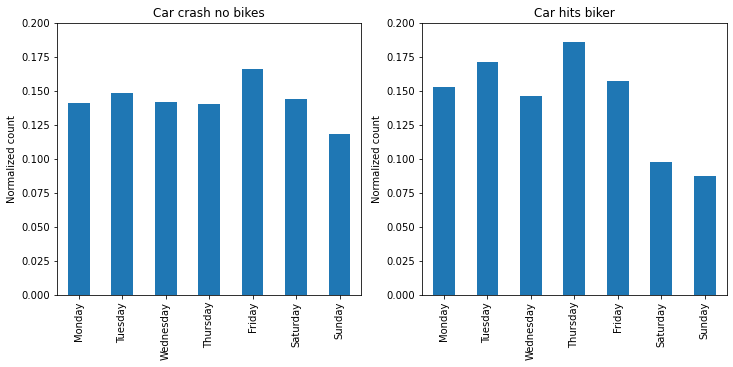

In [234]:
has_cyc = dat[isbike]["day_of_week"]
only_car = dat[iscar]["day_of_week"]

plt.figure(figsize=[12,5])

ax1 = plt.subplot(121)
only_car.value_counts(normalize=True)\
    [['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']].plot(kind='bar')
ax1.set(ylim=(0, .2))
plt.title('Car crash no bikes')
plt.ylabel('Normalized count')

ax2 = plt.subplot(122)
has_cyc.value_counts(normalize=True)\
    [['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']].plot(kind='bar')
ax2.set(ylim=(0, .2))
plt.title('Car hits biker')
plt.ylabel('Normalized count');

## When we look at crashes without or with a biker getting hit, we see that bikers tend to get hit more on weekdays than weekends compared with all crashes

In [235]:
A = has_cyc.value_counts()\
                                [['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
A2 = A.rename_axis('unique_values').to_frame('counts')

B = dat[isbike | iscar]["day_of_week"].value_counts()\
                                [['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
B2 = B.rename_axis('unique_values').to_frame('counts')

C = [[A], [B]]

chi2p = stats.chi2_contingency(C)
print('p = ' + str(chi2p[1]))

p = 1.0908975081958974e-05


Using the same type of analysis as above, we see that the proportions of crashes across the days of the week are different for bikers. Again, this data could be analyzed using circular statistics with continous time through weeks.

## This, along with the time-of-day data, seems to imply that bikers are getting hit more when commuting to work or school, and that the evening commutes are especially dangerous.

## This dataset also has location data (x and y coordinates) and could be used, along with the time, day, and weather conditions, to advise on when and where bikers' routes would be safest.